Data Augmentation splitting

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import FileLink, display

# 1) Load your CSV
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')

# 2) Stratified splits: 80% train, 10% val, 10% test
label_col = 'Label'
# first split off 10% for test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[label_col],
    random_state=777
)
# then split the 90% into 80/10
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    stratify=train_val_df[label_col],
    random_state=777
)

# 3) Save each split as CSV
train_df.to_csv('train.csv', index=False)
val_df.to_csv('val.csv', index=False)
test_df.to_csv('test.csv', index=False)

# 4) Display download links in notebook
print("Download your splits:")
display(FileLink('train.csv'))
display(FileLink('val.csv'))
display(FileLink('test.csv'))

Download your splits:


/content/train.csv

/content/val.csv

/content/test.csv

#Part-B [15 points]: Multiclass App Review Classification: from scratch

Dataset analysis and report on important statistics.

,review,Label
0,يبيله تصليحات كثير,bug_report
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,rating
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,improvement_request
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,rating
4,تبين م لي ي تم ل يب,others


Shape: 2900 rows, 2 columns

Data types:
review    object
Label     object
dtype: object

Missing values per column:
review    0
Label     0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
       review_length
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000

Class distribution:
Label
rating                 1298
bug_report              756
improvement_request     442
others                  404
Name: count, dtype: int64
Label
rating                 0.447586
bug_report             0.260690
improvement_request    0.152414
others                 0.139310
Name: proportion, dtype: float64


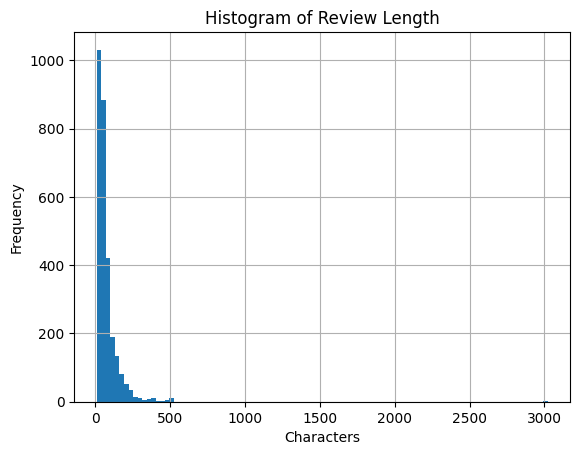

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')
display(df.head())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
print(df['Label'].value_counts())
# view class balance as precentage
print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

# we have a review with 3023 charecters, we could remove it.
# we have data inbalance, we could upscale or downscale, it would be better to upscale

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Conv1D, GlobalMaxPooling1D, SpatialDropout1D, MaxPooling1D, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

In [10]:
# Evaluation & report
def eval_and_report(model, seq, true_y, label_encoder):
    preds = np.argmax(model.predict(seq), axis=1)
    print(classification_report(true_y, preds,
          target_names=label_encoder.classes_))
    cm = confusion_matrix(true_y, preds)
    print("Confusion matrix:\n", cm)

Train the word embeddings from scratch

In [26]:


le = LabelEncoder()
#y = le.fit_transform(labels)

df_train = pd.read_csv('train.csv')
print("Augmented data shape: ",df_train.shape)
# 2) Extract texts and labels
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
# 2) Extract texts and labels
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
# 2) Extract texts and labels
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                          maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),
                          maxlen=MAX_LEN, padding='post')

# Model A: embeddings from scratch + Bi-LSTM
model_scratch = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense( len(le.classes_), activation='softmax')
])
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]


model_scratch.summary()

# Train Model A
history_a = model_scratch.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
emb_matrix = model_scratch.layers[0].get_weights()[0]
print("Embedding matrix shape:", emb_matrix.shape)  # -> (vocab_size, embed_dim)

# save it to disk
np.save('scratch_embeddings.npy', emb_matrix)

# save your tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("=== Model A (scratch) ===")
eval_and_report(model_scratch, test_seq, y_test, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_16 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_23                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.4255 - loss: 1.3094 - val_accuracy: 0.4483 - val_loss: 1.2291
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5011 - loss: 1.1804 - val_accuracy: 0.5805 - val_loss: 1.0864
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.6569 - loss: 0.8925 - val_accuracy: 0.6351 - val_loss: 0.9528
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8142 - loss: 0.5723 - val_accuracy: 0.6552 - val_loss: 0.9245
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9233 - loss: 0.3151 - val_accuracy: 0.6408 - val_loss: 1.1443
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9669 - loss: 0.1543 - val_accuracy: 0.6351 - val_loss: 1.2224
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9897 - loss: 0.0790 - val_accuracy: 0.6063 - val_loss: 1.3191
Embedding matrix shape: (20000, 128)
=== Model A (scratch) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
        

with augmentations

In [28]:
le = LabelEncoder()
#y = le.fit_transform(labels)

df_train = pd.read_csv('train_augmented.csv')
print("Augmented data shape: ",df_train.shape)
# 2) Extract texts and labels
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
# 2) Extract texts and labels
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
# 2) Extract texts and labels
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# Tokenize
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),
                          maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),
                          maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),
                          maxlen=MAX_LEN, padding='post')

# Model A: embeddings from scratch + Bi-LSTM
model_scratch = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense( len(le.classes_), activation='softmax')
])
model_scratch.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]


model_scratch.summary()

# Train Model A
history_a = model_scratch.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)
emb_matrix = model_scratch.layers[0].get_weights()[0]
print("Embedding matrix shape:", emb_matrix.shape)  # -> (vocab_size, embed_dim)

# save it to disk
np.save('scratch_embeddings_aug.npy', emb_matrix)

# save your tokenizer
with open('tokenizer_aug.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Evaluation & report
def eval_and_report(model, seq, true_y, label_encoder):
    preds = np.argmax(model.predict(seq), axis=1)
    print(classification_report(true_y, preds,
          target_names=label_encoder.classes_))
    cm = confusion_matrix(true_y, preds)
    print("Confusion matrix:\n", cm)

print("=== Model A (scratch) ===")
eval_and_report(model_scratch, test_seq, y_test, le)

Augmented data shape:  (4800, 2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5374 - loss: 1.1711 - val_accuracy: 0.6063 - val_loss: 1.0015
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8814 - loss: 0.3401 - val_accuracy: 0.6638 - val_loss: 0.8879
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9547 - loss: 0.1762 - val_accuracy: 0.6810 - val_loss: 0.8605
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9891 - loss: 0.0607 - val_accuracy: 0.6782 - val_loss: 0.9273
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9947 - loss: 0.0279 - val_accuracy: 0.6782 - val_loss: 1.0841
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9991 - loss: 0.0132 - val_accuracy: 0.6753 - val_loss: 1.2550
Embedding matrix shape: (20000, 128)
=== Model A (scratch) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
                     precision    recall  f1-score   support

         bug_report       0.70      0.70      0.70       151
improvement_

Use precomputed embeddings (similar to word2vec or Glove for Arabic)

For ensuring Gensim works

In [29]:
!pip install --upgrade numpy
!pip install --upgrade gensim
!clear

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 127.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━

In [7]:
# Download AraVec embedding
!wget "https://archive.org/download/aravec2.0/tweet_cbow_300.zip"
!unzip "tweet_cbow_300.zip"

--2025-05-10 19:36:16--  https://archive.org/download/aravec2.0/tweet_cbow_300.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia803107.us.archive.org/0/items/aravec2.0/tweet_cbow_300.zip [following]
--2025-05-10 19:36:16--  https://ia803107.us.archive.org/0/items/aravec2.0/tweet_cbow_300.zip
Resolving ia803107.us.archive.org (ia803107.us.archive.org)... 207.241.232.157
Connecting to ia803107.us.archive.org (ia803107.us.archive.org)|207.241.232.157|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 746111232 (712M) [application/zip]
Saving to: ‘tweet_cbow_300.zip’

tweet_cbow_300.zip  100%[===================>] 711.55M  10.6MB/s    in 46s     

2025-05-10 19:37:02 (15.6 MB/s) - ‘tweet_cbow_300.zip’ saved [746111232/746111232]

Archive:  tweet_cbow_300.zip
  inflating: tweets_cbow_300         
  inflating: tweets_cbo

In [10]:
import numpy as np
import gensim
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

# 1) Load your pre‐trained Word2Vec model
w2v_model = gensim.models.Word2Vec.load('tweets_cbow_300')
le = LabelEncoder()

df_train = pd.read_csv('train.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# 2) Cleaning / normalizing function (as you provided)
import re
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",
              '"',"ـ","'","ى","\\",'\n','\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","","ي","",' ',' ',' ',' ? ',' ؟ ',' ! ']
    # remove tashkeel
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', "", text)
    # collapse repeated chars
    text = re.sub(r'(.)\1+', r"\1\1", text)
    # simple normalizations
    text = text.replace('وو','و').replace('يي','ي').replace('اا','ا')
    for s, r in zip(search, replace):
        text = text.replace(s, r)
    return text.strip()

# 3) Apply cleaning before tokenization
X_train = [ clean_str(t) for t in X_train ]
X_val   = [ clean_str(t) for t in X_val ]
X_test  = [ clean_str(t) for t in X_test ]

# (re‐tokenize & pad your sequences here, if needed)
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=MAX_LEN, padding='post')

# 4) Build the embedding matrix from the gensim model
embed_dim   = w2v_model.vector_size
word_index  = tokenizer.word_index
num_tokens  = min(332000, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embed_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # OOV words: you can leave as zeros or random‐initialize
        embedding_matrix[i] = np.random.normal(size=(embed_dim,))

# 5) Define & compile Model B using these embeddings
model_pretrained = Sequential([
    Embedding(
        input_dim=num_tokens,
        output_dim=embed_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_pretrained.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]

model_pretrained.summary()

# Train Model A
history_b = model_pretrained.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

print("\n=== Model B (pre-trained embeddings) ===")
eval_and_report(model_pretrained, test_seq, y_test, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     2,568,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,568,600 (9.80 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,568,600 (9.80 MB)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.4462 - loss: 1.2359 - val_accuracy: 0.5891 - val_loss: 1.0244
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.6586 - loss: 0.9221 - val_accuracy: 0.6408 - val_loss: 0.9004
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7153 - loss: 0.7638 - val_accuracy: 0.6638 - val_loss: 0.8446
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7779 - loss: 0.6308 - val_accuracy: 0.6868 - val_loss: 0.8155
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8204 - loss: 0.5187 - val_accuracy: 0.6638 - val_loss: 0.8327
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8454 - loss: 0.4440 - val_accuracy: 0.6839 - val_loss: 0.8187
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.8825 - loss: 0.3722 - val_accuracy: 0.6839 - val_loss: 0.8382

=== Model B (pre-trained embeddings) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
                     precisio

With augmentation

In [11]:
import numpy as np
import gensim
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential

# 1) Load your pre‐trained Word2Vec model
w2v_model = gensim.models.Word2Vec.load('tweets_cbow_300')
le = LabelEncoder()

df_train = pd.read_csv('train_augmented.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = le.fit_transform(df_train['Label'])

df_val = pd.read_csv('val.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = le.transform(df_val['Label'])

df_test = pd.read_csv('test.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = le.transform(df_test['Label'])

# 2) Cleaning / normalizing function (as you provided)
import re
def clean_str(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",
              '"',"ـ","'","ى","\\",'\n','\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا",
               "","","","","ي","",' ',' ',' ',' ? ',' ؟ ',' ! ']
    # remove tashkeel
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', "", text)
    # collapse repeated chars
    text = re.sub(r'(.)\1+', r"\1\1", text)
    # simple normalizations
    text = text.replace('وو','و').replace('يي','ي').replace('اا','ا')
    for s, r in zip(search, replace):
        text = text.replace(s, r)
    return text.strip()

# 3) Apply cleaning before tokenization
X_train = [ clean_str(t) for t in X_train ]
X_val   = [ clean_str(t) for t in X_val ]
X_test  = [ clean_str(t) for t in X_test ]

# (re‐tokenize & pad your sequences here, if needed)
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train),maxlen=MAX_LEN, padding='post')
val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val),maxlen=MAX_LEN, padding='post')
test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=MAX_LEN, padding='post')

# 4) Build the embedding matrix from the gensim model
embed_dim   = w2v_model.vector_size
word_index  = tokenizer.word_index
num_tokens  = min(332000, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embed_dim))

for word, i in word_index.items():
    if i >= num_tokens:
        continue
    if word in w2v_model.wv.key_to_index:
        embedding_matrix[i] = w2v_model.wv[word]
    else:
        # OOV words: you can leave as zeros or random‐initialize
        embedding_matrix[i] = np.random.normal(size=(embed_dim,))

# 5) Define & compile Model B using these embeddings
model_pretrained = Sequential([
    Embedding(
        input_dim=num_tokens,
        output_dim=embed_dim,
        weights=[embedding_matrix],
        input_length=MAX_LEN,
        trainable=False
    ),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])
model_pretrained.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]

model_pretrained.summary()

# Train Model A
history_b = model_pretrained.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

print("\n=== Model B (pre-trained embeddings) ===")
eval_and_report(model_pretrained, test_seq, y_test, le)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     2,572,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,572,500 (9.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,572,500 (9.81 MB)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.6998 - loss: 0.8134 - val_accuracy: 0.6810 - val_loss: 0.9014
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8724 - loss: 0.3575 - val_accuracy: 0.6609 - val_loss: 0.8492
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9078 - loss: 0.2524 - val_accuracy: 0.7098 - val_loss: 0.7869
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9369 - loss: 0.1903 - val_accuracy: 0.7011 - val_loss: 0.8145
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9503 - loss: 0.1583 - val_accuracy: 0.7011 - val_loss: 0.7952
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9622 - loss: 0.1266 - val_accuracy: 0.7040 - val_loss: 0.8292

=== Model B (pre-trained embeddings) ===
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
                     precision    recall  f1-score   support

         bug_report       0.69      0.77      0.73       151
improvement_request       0.68   

Classification analysis and possible improvements.

# Possible improvements
"""
- **Hyperparameter tuning:** grid-search over LSTM hidden units, dropout rate, learning rate.
- **Stacked RNNs or GRU:** try 2-layer LSTM/GRU or switch to GRU for faster training.
- **Bidirectional & Attention:** add an attention layer on top of the RNN outputs.
- **Fine-tuning embeddings:** set trainable=True for the Embedding layer in Model B.
- **Data augmentation:** back-translation or synonym replacement on reviews.
- **Class imbalance handling:** use class_weights or focal loss if your label counts are skewed.
- **Ensemble:** average predictions of multiple architectures.
"""

#Part-C [15 points]: Multilabel App Review Classification: from scratch

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import FileLink, display

# 1) Load your CSV
df = pd.read_csv('/content/App Reviews-Multilabel.csv')

# 2) Stratified splits: 80% train, 10% val, 10% test
#label_col = ["bug_report",	"improvement_request",	"rating",	"others"]
# first split off 10% for test
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=777
)
# then split the 90% into 80/10
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15,
    random_state=777
)

# 3) Save each split as CSV
train_df.to_csv('train_multi.csv', index=False)
val_df.to_csv('val_multi.csv', index=False)
test_df.to_csv('test_multi.csv', index=False)

# 4) Display download links in notebook
print("Download your splits:")
display(FileLink('train_multi.csv'))
display(FileLink('val_multi.csv'))
display(FileLink('test_multi.csv'))

Download your splits:


/content/train_multi.csv

/content/val_multi.csv

/content/test_multi.csv

Dataset analysis and report on important statistics.

,review,bug_report,improvement_request,rating,others
0,يبيله تصليحات كثير,1,1,1,0
1,ماتحملت ابدددددا ونا دفعت فلوس 🤔😕,0,1,1,1
2,اتمنى منكم عمل خيار لتفضيل المسلسل بالكامل عوض...,0,1,1,0
3,ممتاز وبسيط وتشغيله لا يؤثر على سرعة الانترنت,0,0,1,0
4,تبين م لي ي تم ل يب,0,0,1,1


Shape: 2900 rows, 5 columns

Data types:
review                 object
bug_report              int64
improvement_request     int64
rating                  int64
others                  int64
dtype: object

Missing values per column:
review                 0
bug_report             0
improvement_request    0
rating                 0
others                 0
dtype: int64

Review length summary:
count    2900.000000
mean       74.374828
std        87.071689
min        10.000000
25%        34.000000
50%        52.000000
75%        85.000000
max      3023.000000
Name: review_length, dtype: float64
        bug_report  improvement_request       rating       others  \
count  2900.000000          2900.000000  2900.000000  2900.000000   
mean      0.401379             0.380345     0.679655     0.282759   
std       0.490262             0.485555     0.466690     0.450418   
min       0.000000             0.000000     0.000000     0.000000   
25%       0.000000             0.000000     0.000000    

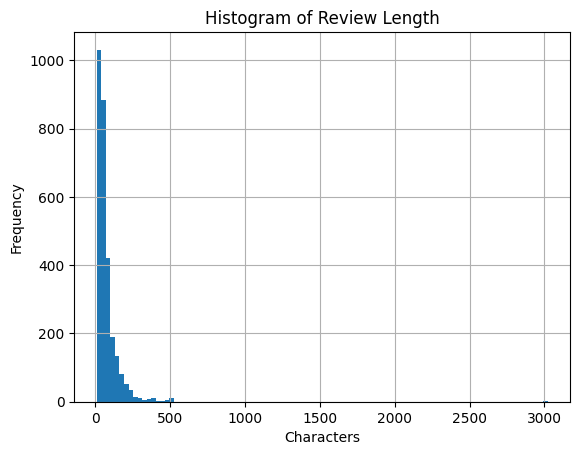

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
# read csv into data frame
df = pd.read_csv('/content/App Reviews-Multilabel.csv')
display(df.head())
# # Print the dataset’s shape and a preview of the first rows.
# print(df.shape)
# # Show data types, non-null counts, and missing-value totals.
# # check if thier is null data
# print(df.isnull().sum())
# Basic dataset info
print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nData types:")
print(df.dtypes)
print("\nMissing values per column:")
print(df.isnull().sum())

# Review‐length feature
df['review_length'] = df['review'].str.len()
print("\nReview length summary:")
print(df['review_length'].describe())

# Provide numeric and categorical summaries.
print(df.describe())

# view class balance
print("\nClass distribution:")
bug_report_counts = df['bug_report'].sum()
improvement_request_counts = df['improvement_request'].sum()
rating_counts = df['rating'].sum()
others_counts = df['others'].sum()
print(bug_report_counts,"bug_report")
print(improvement_request_counts,"improvement_request")
print(rating_counts,"rating")
print(others_counts,"others")

# viewing class balance as precentage
total_sum = bug_report_counts + improvement_request_counts + rating_counts + others_counts
print("As precentages")
print((bug_report_counts/total_sum)*100,"%","bug_report")
print((improvement_request_counts/total_sum)*100,"%","improvement_request")
print((rating_counts/total_sum)*100,"%","rating")
print((others_counts/total_sum)*100,"%","others")
#print(df['Label'].value_counts(normalize=True))

# Plot review length histogram
plt.figure()
df['review_length'].hist(bins=100)
plt.title('Histogram of Review Length')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.show()

# we have a review with 3023 charecters, we could remove!

Implement a from-scratch model
o (RNN-based model: LSTM/GRU/Bidirectional/stacked/…)

In [16]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    hamming_loss,
    accuracy_score,
    ConfusionMatrixDisplay,
    multilabel_confusion_matrix
)

def eval_and_report_multilabel(model, seq, true_y, label_names, threshold=0.5):
    # 1) Predict probabilities and binarize
    preds_proba = model.predict(seq)
    preds = (preds_proba >= threshold).astype(int)

    # 2) Per‐label reports
    cms = multilabel_confusion_matrix(true_y, preds)
    print(cms)
    # for idx, label in enumerate(label_cols):
    #     disp = ConfusionMatrixDisplay(cms[idx],
    #                                   display_labels=['negative','positive'])
    #     disp.plot(cmap=plt.cm.Blues)
    #     plt.title(label)
    #     plt.show()
    # 3) Overall multilabel metrics
    print("\n=== Overall Multilabel Metrics ===")
    print(f"Hamming Loss:    {hamming_loss(true_y, preds):.4f}")
    print(f"Subset Accuracy: {accuracy_score(true_y, preds):.4f}")



# This returns an array of shape (n_labels, 2, 2)
# where for each label i: cm[i] = [[TN, FP],
#                                [FN, TP]]
#cms = multilabel_confusion_matrix(y_true, y_pred_bin)


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import multilabel_confusion_matrix

label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]
df_train = pd.read_csv('train_multi.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = df_train[label_cols]

df_val = pd.read_csv('val_multi.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = df_val[label_cols]

df_test = pd.read_csv('test_multi.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = df_test[label_cols]

# 2) Identify text & one-hot columns
# text_col   = 'review'


# # 3) Prepare X and y
# texts = df[text_col].astype(str).tolist()
# y     = df[label_cols].values             # shape (n_samples, 4)
# y_int = np.argmax(y, axis=1)              # integer labels for metrics/stratify

# # 4) Decide whether we can stratify
# counts = np.bincount(y_int)
# strat_arg = y_int if counts.min() >= 2 else None

# # 5) Split
# X_train, X_test, y_train, y_test = train_test_split(
#     texts, y, test_size=0.2,
#     stratify=strat_arg,
#     random_state=777
# )
# X_train, X_val, y_train, y_val = train_test_split(
#     X_train, y_train, test_size=0.15,
#     random_state=777
# )


# 6) Tokenize & pad
MAX_VOCAB = 20000
MAX_LEN   = 600

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 7) Build & compile the model
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(len(label_cols), activation='softmax')
])
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
# 8) Train
history = model.fit(
    train_seq, np.array(y_train),
    validation_data=(val_seq, np.array(y_val)),
    epochs=25, batch_size=64, callbacks=callbacks
)

eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.3368 - loss: 2.4457 - val_accuracy: 0.3103 - val_loss: 2.5901
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3178 - loss: 3.0511 - val_accuracy: 0.3103 - val_loss: 2.6881
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3089 - loss: 3.2939 - val_accuracy: 0.3103 - val_loss: 2.6108
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3290 - loss: 3.2337 - val_accuracy: 0.3103 - val_loss: 2.6693
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2929 - loss: 3.4274 - val_accuracy: 0.3103 - val_loss: 2.6927
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3341 - loss: 3.2310 - val_accuracy: 0.3103 - val_loss: 2.6642
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3062 - loss: 3.3709 - val_accuracy: 0.3103 - val_loss: 2.7573
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3461 - loss: 3.2902 - val_accuracy: 0.3103 - v

KeyboardInterrupt: 

You can use the best embedding from Part-B

Classification analysis and possible improvements.

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import pickle

label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]
df_train = pd.read_csv('train_multi.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = df_train[label_cols].values.astype(int)

df_val = pd.read_csv('val_multi.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = df_val[label_cols].values.astype(int)

df_test = pd.read_csv('test_multi.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = df_test[label_cols].values.astype(int)

# TEXT PREPROCESSING
MAX_VOCAB = 20000
MAX_LEN    = 600

# Convert texts to padded sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 4) EMBEDDING MATRIX LOADING
# Assumes you exported embedding_matrix.npy from Part B
EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

# 5) BUILD RNN-BASED MULTILABEL MODEL
vocab_size, embedding_dim = embedding_matrix.shape
num_labels = y_train.shape[1]
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_labels, activation='sigmoid', name='output')
])
# model = Sequential([
#     Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         input_length=MAX_SEQ_LEN,
#         trainable=False,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(num_labels, activation='sigmoid', name='output')
# ], name='multilabel_rnn')
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 6) TRAIN
EPOCHS = 20
BATCH_SIZE = 32
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
history = model.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)
eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.3291 - loss: 0.6496 - val_accuracy: 0.3103 - val_loss: 0.6238
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.3902 - loss: 0.5821 - val_accuracy: 0.5690 - val_loss: 0.5409
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.6323 - loss: 0.4481 - val_accuracy: 0.5747 - val_loss: 0.4877
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.7045 - loss: 0.3044 - val_accuracy: 0.5747 - val_loss: 0.5278
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7308 - loss: 0.2086 - val_accuracy: 0.5575 - val_loss: 0.5638
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7150 - loss: 0.1409 - val_accuracy: 0.5316 - val_loss: 0.6585
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
[[[279  62]
  [ 55 184]]

 [[237 105]
  [ 66 172]]

 [[113  83]
  [ 53 331]]

 [[404  17]
  [125  34]]]

=== Overall Multilabel Metrics ===
Hamming Loss:    0.2440
Subset Accuracy: 0.3569


With augmentation

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
import pickle

label_cols = ["bug_report",	"improvement_request",	"rating",	"others"]
df_train = pd.read_csv('train_multi_aug.csv')
X_train = df_train['review'].astype(str).tolist()
y_train = df_train[label_cols].values.astype(int)

df_val = pd.read_csv('val_multi.csv')
X_val = df_val['review'].astype(str).tolist()
y_val = df_val[label_cols].values.astype(int)

df_test = pd.read_csv('test_multi.csv')
X_test = df_test['review'].astype(str).tolist()
y_test = df_test[label_cols].values.astype(int)

# TEXT PREPROCESSING
MAX_VOCAB = 20000
MAX_LEN    = 600

# Convert texts to padded sequences
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
train_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=MAX_LEN, padding='post'
)
val_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_val),
    maxlen=MAX_LEN, padding='post'
)
test_seq = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=MAX_LEN, padding='post'
)

# 4) EMBEDDING MATRIX LOADING
# Assumes you exported embedding_matrix.npy from Part B
EMBEDDING_PATH = 'tweets_cbow_300.wv.vectors.npy'
embedding_matrix = np.load(EMBEDDING_PATH)
print(f'\nLoaded embedding matrix: {embedding_matrix.shape}')

# 5) BUILD RNN-BASED MULTILABEL MODEL
vocab_size, embedding_dim = embedding_matrix.shape
num_labels = y_train.shape[1]
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(num_labels, activation='sigmoid', name='output')
])
# model = Sequential([
#     Embedding(
#         input_dim=vocab_size,
#         output_dim=embedding_dim,
#         weights=[embedding_matrix],
#         input_length=MAX_SEQ_LEN,
#         trainable=False,
#         name='embedding'
#     ),
#     Bidirectional(
#         LSTM(128, return_sequences=False, recurrent_dropout=0.2),
#         name='bilstm'
#     ),
#     Dropout(0.3, name='dropout_1'),
#     Dense(64, activation='relu', name='dense_1'),
#     Dropout(0.3, name='dropout_2'),
#     Dense(num_labels, activation='sigmoid', name='output')
# ], name='multilabel_rnn')
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

# 6) TRAIN
EPOCHS = 20
BATCH_SIZE = 32
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,              # stop after 3 epochs w/o improvement
        restore_best_weights=True
    )
]
history = model.fit(
    train_seq, y_train,
    validation_data=(val_seq, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)
eval_and_report_multilabel(
    model,
    seq=test_seq,
    true_y=y_test,
    label_names=label_cols,
    threshold=0.5
)


Loaded embedding matrix: (331679, 300)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2694 - loss: 0.6195 - val_accuracy: 0.4684 - val_loss: 0.5921
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5193 - loss: 0.2090 - val_accuracy: 0.4655 - val_loss: 0.7991
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5645 - loss: 0.0506 - val_accuracy: 0.4511 - val_loss: 0.8362
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5570 - loss: 0.0265 - val_accuracy: 0.4598 - val_loss: 1.0996
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
[[[301  40]
  [  6 233]]

 [[255  87]
  [ 41 197]]

 [[190   6]
  [ 15 369]]

 [[356  65]
  [ 17 142]]]

=== Overall Multilabel Metrics ===
Hamming Loss:    0.1194
Subset Accuracy: 0.5707


#Part-D [15 points]: Multiclass App Review Classification: Finetune an MLM


Fine-tune a Bert-type model like Arabert or Marbert

In [19]:
# install the AraBERT preprocessor
!pip install arabert

# install Farasa (required by the preprocessor for v1 & v2 tokenization)
!pip install farasapy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.8 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=592343686a79dc140f100f592787a145cec0685381646eeae8a3dc7755b51253
  Stored in directory: /root/.cache/pip/wheels/94/08/b4/78657b1541bb704b088317b52429ee4016d9888fe47dbb130f
Successfully built emoji


In [30]:
from arabert.preprocess import ArabertPreprocessor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)
from transformers import TrainingArguments

Token indices sequence length is longer than the specified maximum sequence length for this model (1008 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


(array([  0.,  28., 132., 195., 274., 307., 264., 217., 189., 166., 146.,
        129., 102.,  86.,  57.,  69.,  41.,  40.,  47.,  26.,  36.,  33.,
         26.,  22.,  33.,  26.,  12.,  20.,  18.,  10.,   9.,   8.,  12.,
          9.,  10.,  11.,   5.,   3.,   7.,   7.,   3.,   1.,   4.,   0.,
          1.,   0.,   3.,   2.,   4.,   2.,   2.,   3.,   1.,   2.,   2.,
          0.,   4.,   5.,   1.,   1.,   1.,   3.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   2.,   0.,   5.,   2.,   1.,   2.,   2.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

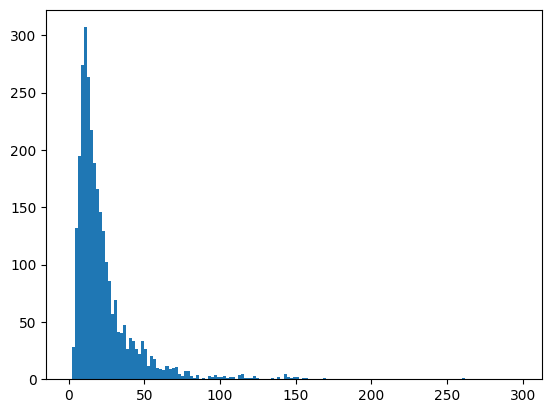

In [24]:
tok = AutoTokenizer.from_pretrained('aubmindlab/bert-large-arabertv2')
print("Training Sentence Lengths: ")
df = pd.read_csv('/content/App Reviews-SingleLabel-Multiclass.csv')
plt.hist([ len(tok.tokenize(sentence)) for sentence in df['review'].to_list()],bins=range(0,300,2))

In [25]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > 200 for sentence in df['review'].to_list()]))

Truncated training sequences:  4


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        'accuracy': accuracy_score(labels, preds),
        **{f'{lab}_f1': score
           for lab, score in
           zip(label_names,
               __import__('sklearn.metrics').metrics.f1_score(
                   labels, preds, average=None
               ))
        }
    }

In [38]:
le = LabelEncoder()
df_train = pd.read_csv('train.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

df_train['Label'] = le.fit_transform(df_train['Label'])
# now transform val & test
df_val  ['Label'] = le.transform(df_val['Label'])
df_test ['Label'] = le.transform(df_test['Label'])
label_names = le.classes_
# Dataset class to feed into AraBert
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# create dataset and get tokenizer ( pretrained )
MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(
    df_train['review'].tolist(),
    df_train['Label'].tolist(),
    tokenizer
)
val_ds = ReviewDataset(
    df_val['review'].tolist(),
    df_val['Label'].tolist(),
    tokenizer
)
test_ds = ReviewDataset(
    df_test['review'].tolist(),
    df_test['Label'].tolist(),
    tokenizer
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# build the MLM
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# training arguments
training_args = TrainingArguments(
    output_dir='./bert_reviews',
    overwrite_output_dir=True,

    # enable training & evaluation
    do_train=True,
    do_eval=True,

    # run eval and saving at the end of each epoch
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,        # keep only the best/last checkpoint

    # core hyperparameters
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,

    # log every 100 steps
    logging_strategy='steps',
    logging_steps=100,

    # pick up the best model automatically
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)
# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,        # ← pad to max length in each batch
    compute_metrics=compute_metrics
)

# 9) RUN TRAINING
trainer.train()

# 10) EVALUATION
metrics = trainer.evaluate()
print(metrics)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-38-00c77c4266bc>:92: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Bug Report F1,Improvement Request F1,Others F1,Rating F1
1,1.247300,1.302875,0.448276,0.000000,0.000000,0.000000,0.619048
2,1.303900,1.273953,0.448276,0.000000,0.000000,0.000000,0.619048
3,1.317100,1.273474,0.448276,0.000000,0.000000,0.000000,0.619048
4,1.303200,1.275692,0.448276,0.000000,0.000000,0.000000,0.619048
5,1.291900,1.272870,0.448276,0.000000,0.000000,0.000000,0.619048
6,1.291800,1.277792,0.448276,0.000000,0.000000,0.000000,0.619048


KeyboardInterrupt: 

In [ ]:
preds_output = trainer.predict(test_ds)
preds = np.argmax(preds_output.predictions, axis=-1)
print(classification_report(df_test['Label'], preds, target_names=[str(l) for l in label_names]))

With Augmentation

In [ ]:
le = LabelEncoder()
df_train = pd.read_csv('train_augmented.csv')
df_val = pd.read_csv('val.csv')
df_test = pd.read_csv('test.csv')

df_train['Label'] = le.fit_transform(df_train['Label'])
# now transform val & test
df_val  ['Label'] = le.transform(df_val['Label'])
df_test ['Label'] = le.transform(df_test['Label'])
label_names = le.classes_
# Dataset class to feed into AraBert
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

# create dataset and get tokenizer ( pretrained )
MODEL_NAME = 'aubmindlab/bert-large-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_ds = ReviewDataset(
    df_train['review'].tolist(),
    df_train['Label'].tolist(),
    tokenizer
)
val_ds = ReviewDataset(
    df_val['review'].tolist(),
    df_val['Label'].tolist(),
    tokenizer
)
test_ds = ReviewDataset(
    df_test['review'].tolist(),
    df_test['Label'].tolist(),
    tokenizer
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# build the MLM
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

# training arguments
training_args = TrainingArguments(
    output_dir='./bert_reviews',
    overwrite_output_dir=True,

    # enable training & evaluation
    do_train=True,
    do_eval=True,

    # run eval and saving at the end of each epoch
    eval_strategy='epoch',
    save_strategy='epoch',
    save_total_limit=1,        # keep only the best/last checkpoint

    # core hyperparameters
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    weight_decay=0.01,

    # log every 100 steps
    logging_strategy='steps',
    logging_steps=100,

    # pick up the best model automatically
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
)
# 8) TRAINER
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,        # ← pad to max length in each batch
    compute_metrics=compute_metrics
)

# 9) RUN TRAINING
trainer.train()

# 10) EVALUATION
metrics = trainer.evaluate()
print(metrics)

Classification analysis and possible improvements.

#Part-E [15 points]: Multilabel App Review Classification: Finetune an MLM

Fine-tune a Bert-type model like Arabert or Marbert

In [41]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding
)

df_train = pd.read_csv('train_multi.csv')
df_val = pd.read_csv('val_multi.csv')
df_test = pd.read_csv('test_multi.csv')


TEXT_COL = "review"
LABEL_COLS = ['bug_report','improvement_request','rating','others']
num_labels = len(LABEL_COLS)

# ensure label columns are ints 0/1
df_train[LABEL_COLS] = df_train[LABEL_COLS].astype(int)
df_val[LABEL_COLS]   = df_val[LABEL_COLS].astype(int)
df_test[LABEL_COLS]  = df_test[LABEL_COLS].astype(int)


# AraBERT preprocessing
from arabert.preprocess import ArabertPreprocessor
prep = ArabertPreprocessor('aubmindlab/bert-base-arabertv2')
for df_ in (df_train, df_val, df_test):
    df_['review'] = df_['review'].apply(prep.preprocess)

MODEL_NAME = 'aubmindlab/bert-base-arabertv2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts     = texts
        self.labels    = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # tokenize the text
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding=False,
            return_tensors="pt"
        )
        # convert label row to float
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)
        # HuggingFace Trainer will pick up encoding["labels"]
        encoding["labels"] = label_tensor
        # remove the extra batch dim
        return {k: v.squeeze(0) for k, v in encoding.items()}

train_ds = ReviewDataset(df_train[TEXT_COL].tolist(),
                         df_train[LABEL_COLS].values,
                         tokenizer)
val_ds   = ReviewDataset(df_val[TEXT_COL].tolist(),
                         df_val[LABEL_COLS].values,
                         tokenizer)
test_ds  = ReviewDataset(test_df[TEXT_COL].tolist(),
                         df_test[LABEL_COLS].values,
                         tokenizer)

data_collator = DataCollatorWithPadding(tokenizer)

# model (multilabel)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="multi_label_classification"  # triggers BCEWithLogitsLoss
)

training_args = TrainingArguments(
    output_dir="./bert_multilabel",
    overwrite_output_dir=True,
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=3e-5,
    num_train_epochs=3,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="micro_f1",
    greater_is_better=True,
)

# metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = torch.sigmoid(torch.tensor(logits)).numpy()
    preds = (probs >= 0.5).astype(int)
    labels = labels.astype(int)

    micro_f1 = f1_score(labels, preds, average="micro")
    macro_f1 = f1_score(labels, preds, average="macro")
    subset_acc = accuracy_score(labels, preds)

    return {
        "micro_f1": micro_f1,
        "macro_f1": macro_f1,
        "subset_accuracy": subset_acc
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# train and evaluate
trainer.train()
print(trainer.evaluate())

[2025-05-10 20:57:13,611 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-41-fb078ec4d4f2>:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Micro F1,Macro F1,Subset Accuracy
1,0.524000,0.420179,0.785653,0.746157,0.479885
2,0.389500,0.388721,0.790861,0.739413,0.517241
3,0.323800,0.377240,0.812715,0.773404,0.545977


{'eval_loss': 0.377239853143692, 'eval_micro_f1': 0.8127147766323024, 'eval_macro_f1': 0.7734035221658015, 'eval_subset_accuracy': 0.5459770114942529, 'eval_runtime': 0.5975, 'eval_samples_per_second': 582.466, 'eval_steps_per_second': 18.411, 'epoch': 3.0}


KeyError: "None of [Index(['bug_report', 'improvement_request', 'rating', 'others'], dtype='object')] are in the [columns]"

Classification analysis and possible improvements.